**Downloading and uncompressing Oxford-IIIT Pets dataset**

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-06-17 16:19:10--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-06-17 16:19:11--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-06-17 16:19:12--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

**Importing required libraries and API**

In [2]:
import os
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

**Preparing file path of dataset for the model**

In [3]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

**Make the  numPy arrays and split the dataset for train and validation**

In [4]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

**Model architecture**

In [5]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

**compiling and train the model**

In [6]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - loss: 0.9796 - val_loss: 0.8952
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 517ms/step - loss: 0.8867 - val_loss: 0.9285
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 516ms/step - loss: 0.8479 - val_loss: 0.8510
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 539ms/step - loss: 0.8021 - val_loss: 0.7541
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 533ms/step - loss: 0.7750 - val_loss: 0.7609
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 541ms/step - loss: 0.7649 - val_loss: 0.8090
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 518ms/step - loss: 0.7559 - val_loss: 0.7056
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 535ms/step - loss: 0.7408 - val_loss: 0.6840
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 548ms/step - loss: 0.7061 - val_loss: 0.6349
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 542ms/step - loss: 0.6871 - val_loss: 0.6320
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 519ms/step - loss: 0.6442 - val_loss: 0.7825
Epoch 12/50
100/100 ━

 **loss calculation**

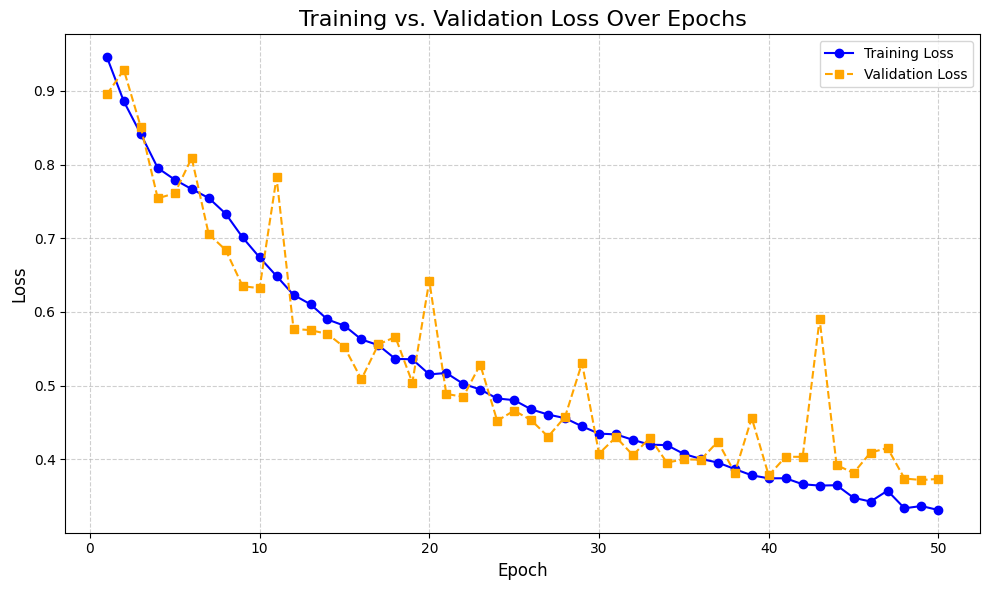

In [7]:
# Extract values
epochs = range(1, len(history.history["loss"]) + 1)
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Create figure
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(epochs, val_loss, marker='s', linestyle='--', color='orange', label='Validation Loss')

# Add titles and labels
plt.title("Training vs. Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Display the randomly selected image and corresponding segmented mask**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


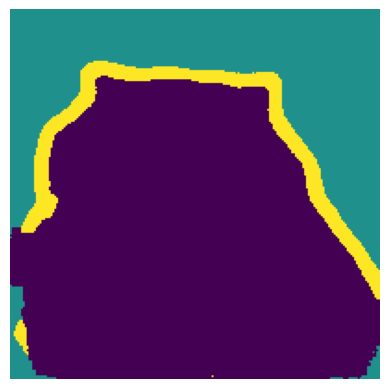

In [8]:
model = keras.models.load_model("oxford_segmentation.keras")

# a random number generated from range 0 to 1000
r = random.randrange(1000)
test_image = val_input_imgs[r]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

In [ ]:
#stop instance runtime to avoid running out of quotas
from google.colab import runtime
runtime.unassign()


***Visualizing intermediate activations***




In [9]:
! pip install -q kaggle             # kaggle installation in colab environment
from google.colab import files      # importing files for handaling directory in colab
import os, shutil, pathlib          # importing os for creating directory, unzipping, copying in colab

In [10]:
files.upload()                      #kaggle API uploading pop-up

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kironmala","key":"308642ad9f40f94905acdae11f2c458d"}'}

In [11]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:06<00:00, 109MB/s] 
100% 812M/812M [00:06<00:00, 139MB/s]


In [13]:
#run this cell one time
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

**required libraries and API**

In [14]:
import os, shutil, pathlib
import numpy as np
import random, glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

**Splitting the dataset**

In [15]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

**preprocessing the data**

In [16]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [17]:
#data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**model building**

In [18]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [19]:
#compile the model and training
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=80,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.4845 - loss: 0.7572 - val_accuracy: 0.5060 - val_loss: 0.6918
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5122 - loss: 0.6948 - val_accuracy: 0.5300 - val_loss: 0.6885
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5429 - loss: 0.7060 - val_accuracy: 0.5710 - val_loss: 0.6797
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5721 - loss: 0.6800 - val_accuracy: 0.5390 - val_loss: 0.6890
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6076 - loss: 0.6728 - val_accuracy: 0.5800 - val_loss: 0.6730
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6295 - loss: 0.6425 - val_accuracy: 0.5900 - val_loss: 0.6810
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6351 - loss: 0.6431 - val_accuracy: 0.6450 - val_loss: 0.6371
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6619 - loss: 0.6210 - val_accuracy: 0.6300 - v

**select a random image from 'dogs-vs-cats' dataset**

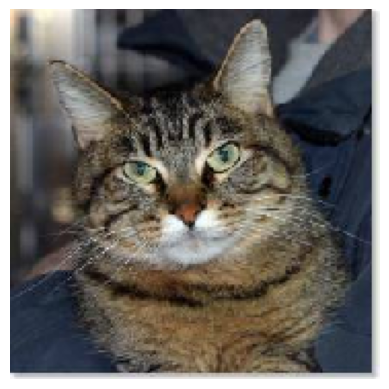

In [20]:
mydir = pathlib.Path("train")
images = glob.glob(os.path.join(mydir, '*.jpg'))
random_image = random.choice(images)


def get_img_array(random_image, target_size):
    img = keras.utils.load_img(
        random_image, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(random_image, target_size=(180, 180))

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

**Model Loading**

In [21]:
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

**Below cell for layer activations**

In [22]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [23]:
activations = activation_model.predict(img_tensor)   #  computing layer activation
first_layer_activation = activations[0]
print(first_layer_activation.shape)                  # visualizing the shape of 1st layer

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
(1, 178, 178, 32)


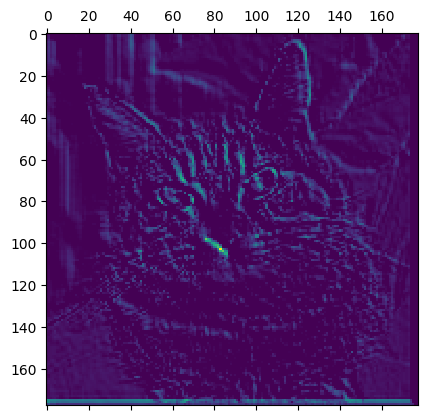

In [24]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")   #Visualizing the fifth channel of 1st layer

**Displaying all channels from each intermediate layer activation**

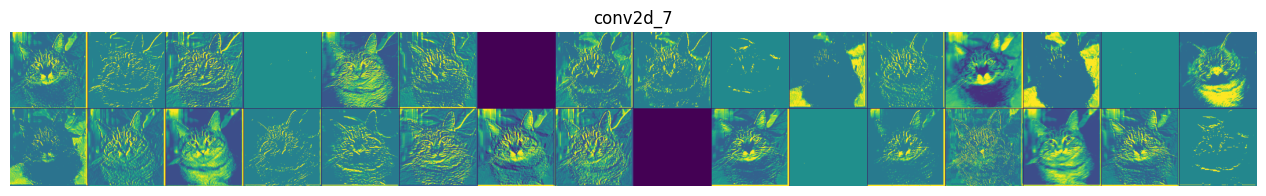

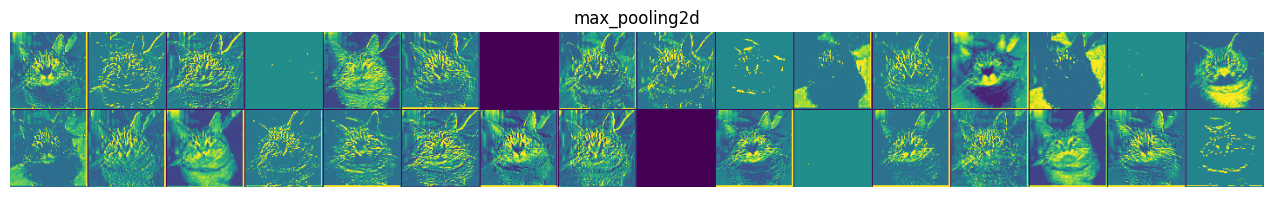

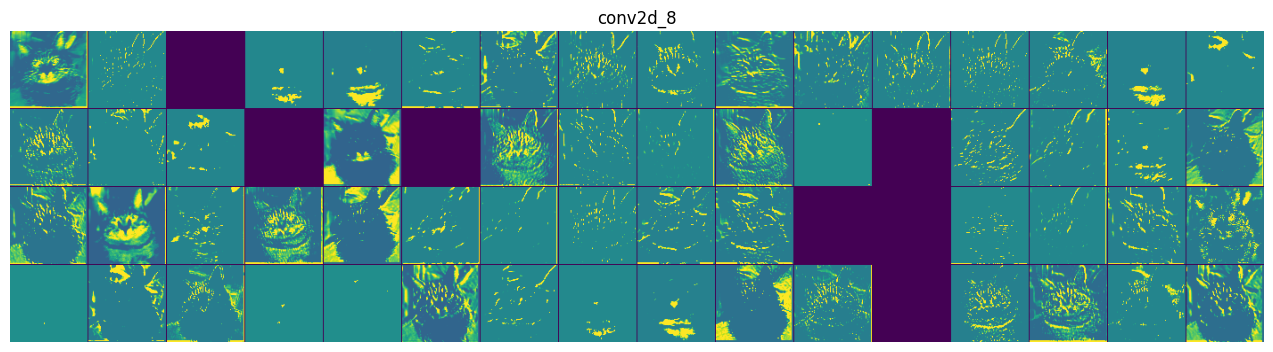

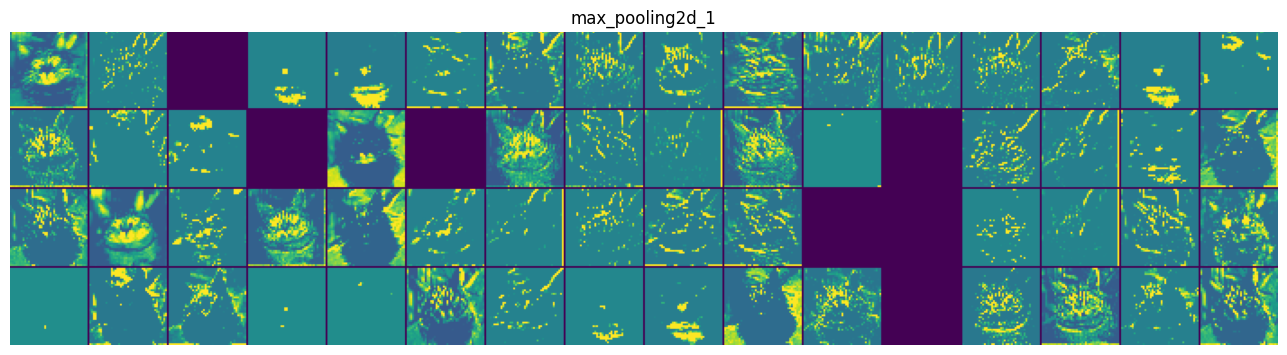

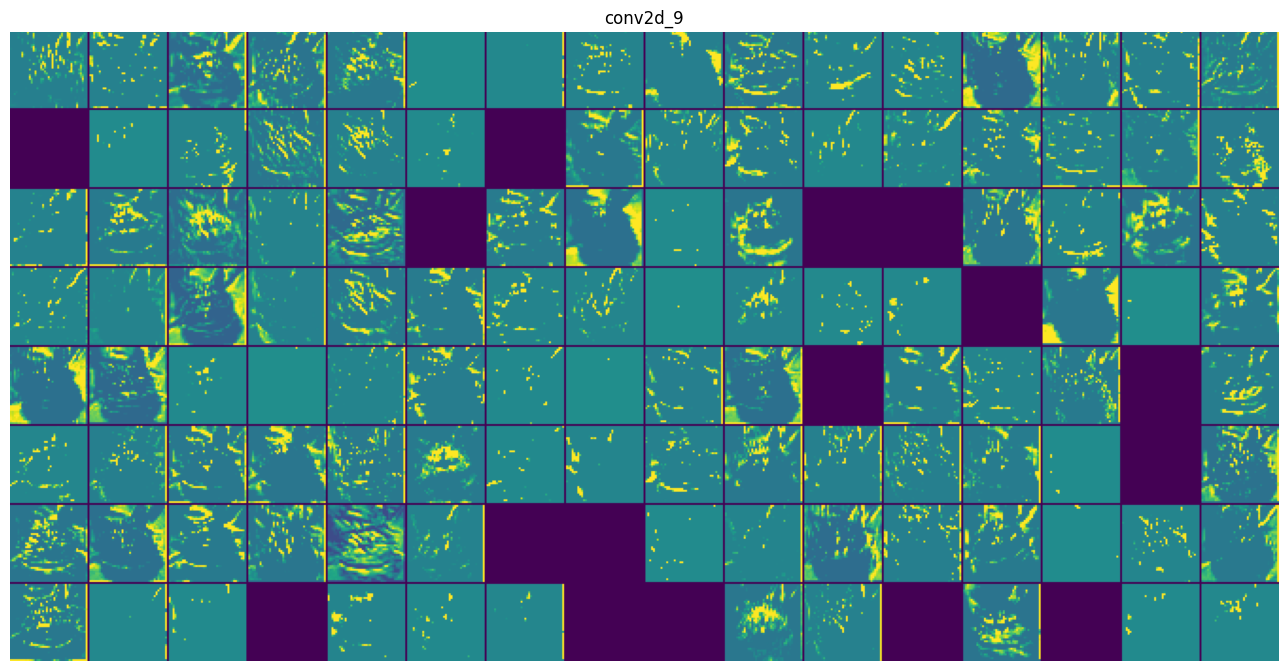

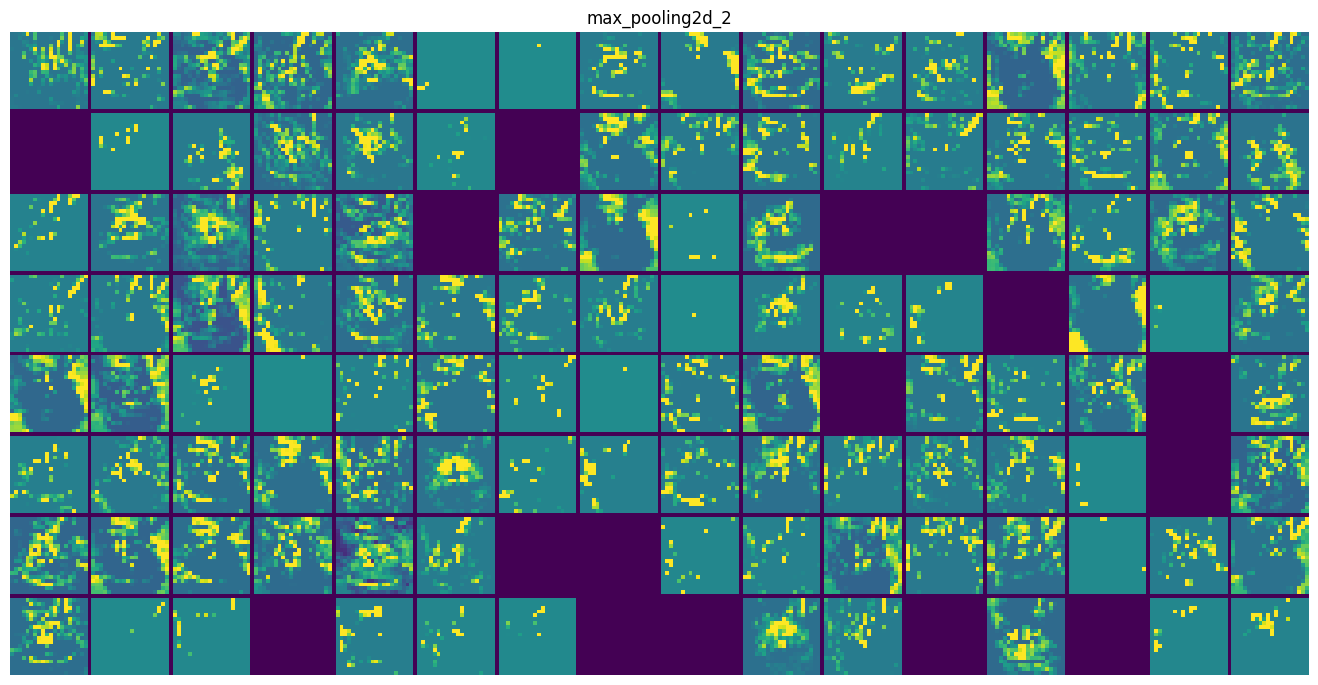

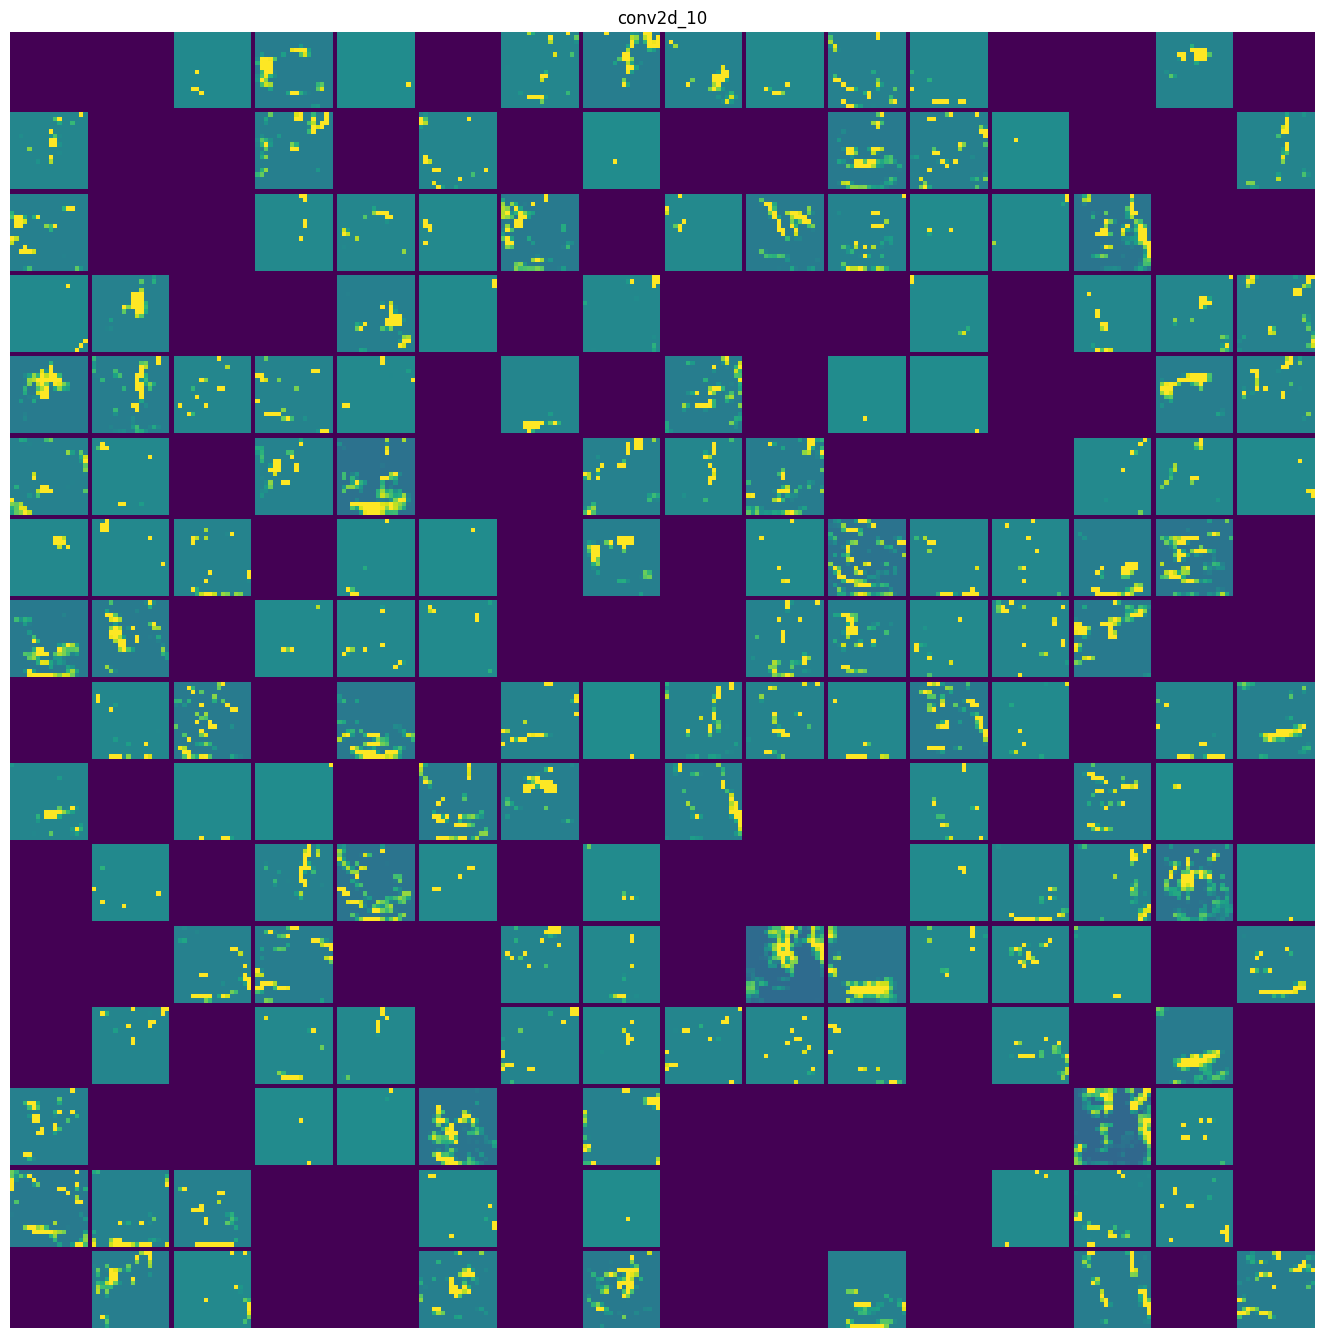

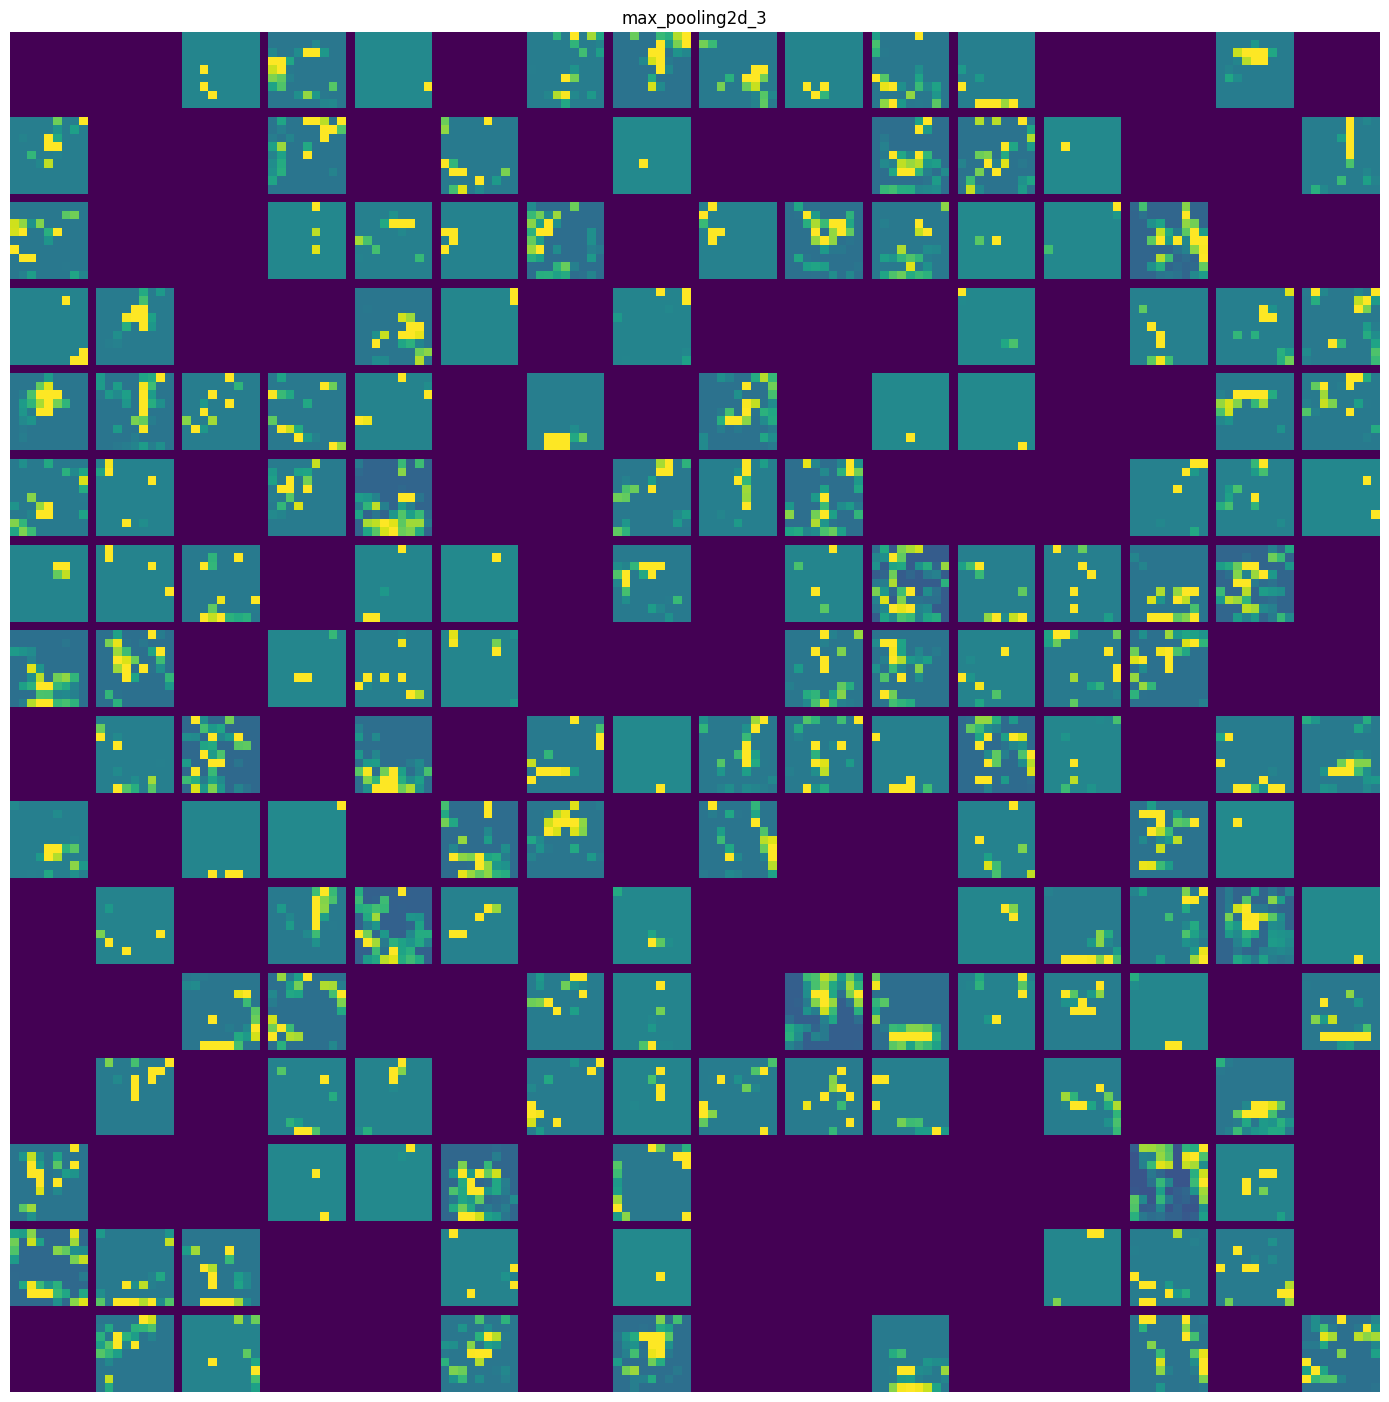

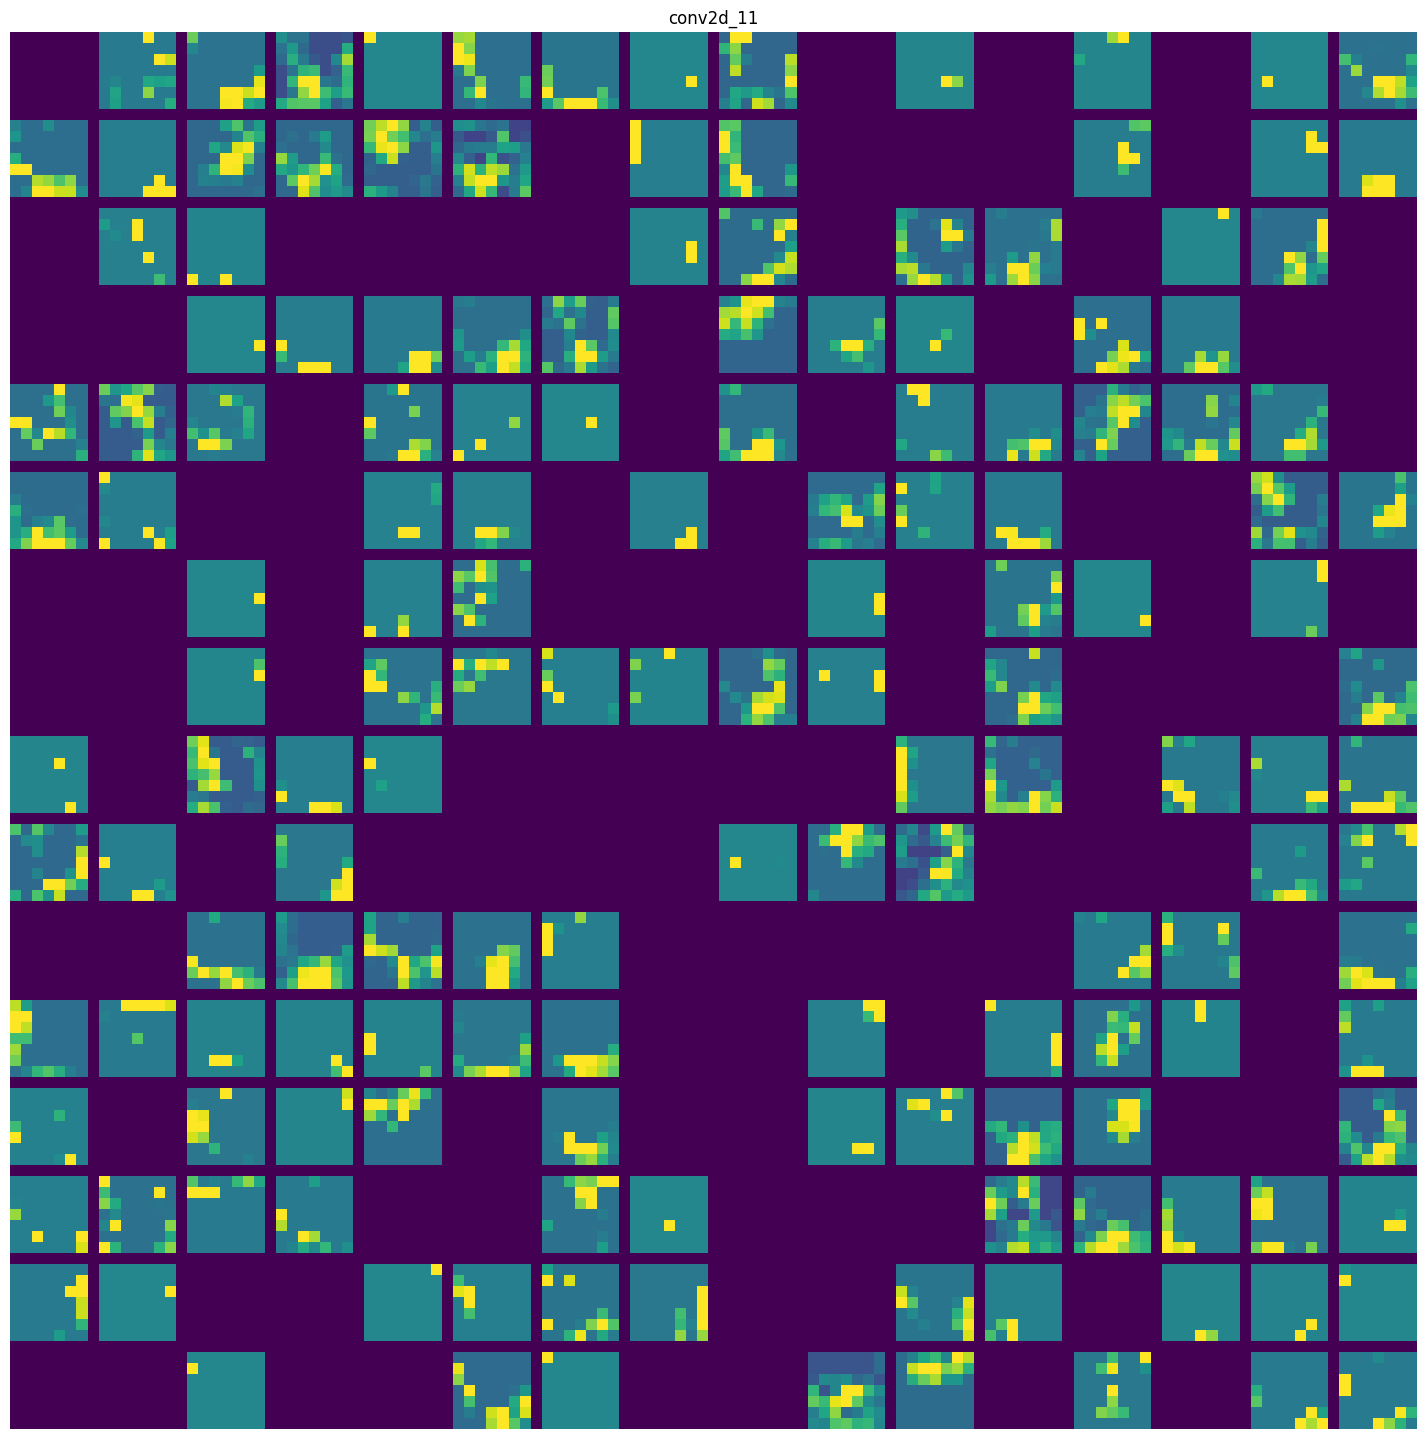

In [25]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

**convnet filters displaying**




In [26]:
import tensorflow as tf

In [27]:
#Instantiating the Xception convolutional base
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
#Printing the names of all convolutional layers in Xception
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_12
block3_sepconv1
block3_sepconv2
conv2d_13
block4_sepconv1
block4_sepconv2
conv2d_14
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_15
block14_sepconv1
block14_sepconv2


In [29]:
#feature extractor model creation
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

#Using feature extractor
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [30]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

**filter visualizations funtion creation**

In [31]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

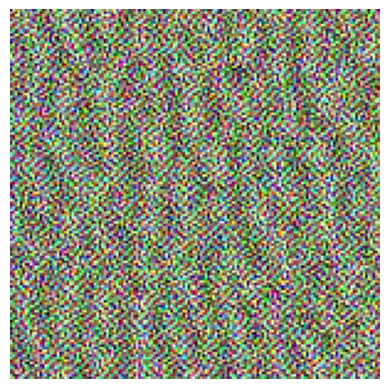

In [32]:
#Utility function to convert a tensor into a valid image
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

filter_index = random.randrange(len(model.layers))
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index)))

**Class Activation Heatmaps**


In [33]:
import matplotlib.cm as cm
import tensorflow as tf

In [34]:
#Loading the Xception network with pretrained weights
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Randomly sample one image from the full 'dogs-vs-cats' image collection**

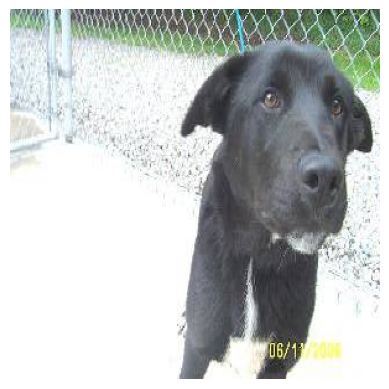

In [35]:
mydir = pathlib.Path("train")
images = glob.glob(os.path.join(mydir, '*.jpg'))
random_image = random.choice(images)


def get_img_array(random_image, target_size):
    img = keras.utils.load_img(
        random_image, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(random_image, target_size=(299, 299, 3))

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [36]:
preds = model.predict(img_tensor)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[('n03775546', 'mixing_bowl', np.float32(1.0)), ('n04127249', 'safety_pin', np.float32(1.8840145e-13)), ('n02105056', 'groenendael', np.float32(1.6340706e-14))]


In [37]:
np.argmax(preds[0])

np.int64(659)

**Configure a model to output the final convolutional feature map**

In [38]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [39]:
#Reapplying the classifier on top of the last convolutional output
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**Obtaining the gradient of the highest scoring class**

In [40]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tensor)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


In [41]:
#Gradient pooling and channel-importance weighting
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

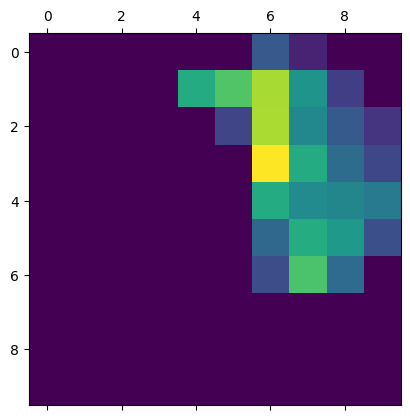

In [42]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Superimposing the heatmap**

In [43]:
import matplotlib.cm as cm

img = keras.utils.load_img(random_image)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "cat_or_dog_heatmap.jpg"
superimposed_img.save(save_path)

<ipython-input-43-2549530361>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


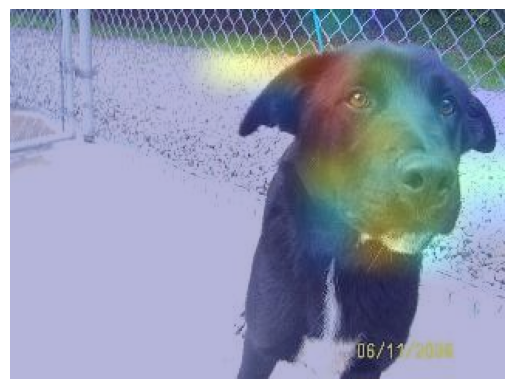

In [44]:
plt.axis("off")
plt.imshow(superimposed_img)
plt.show()